<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


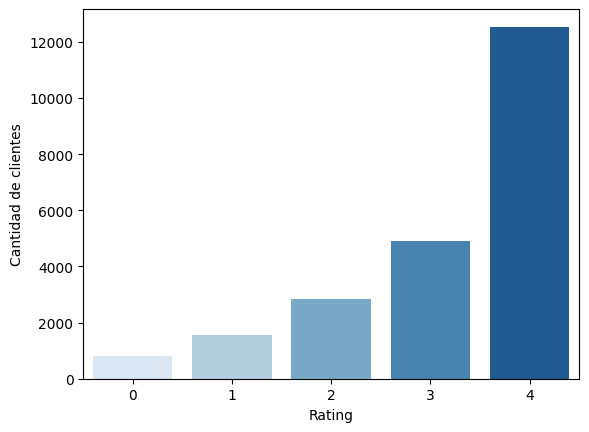

Rating 1: 821 clientes
Rating 2: 1549 clientes
Rating 3: 2823 clientes
Rating 4: 4908 clientes
Rating 5: 12540 clientes


In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase
sns.countplot(data=df_reviews, x='Rating', palette = 'Blues')
plt.xlabel('Rating');plt.ylabel('Cantidad de clientes')
plt.show()

unique_class, counts = np.unique(df_reviews['Rating'], return_counts=True)
for unique_class, counts in zip(unique_class, counts):
  print(f'Rating {unique_class+1}: {counts} clientes')

In [6]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].to_numpy()

In [7]:
# Imprimo cantidad de reviews
print(f'\nEl dataset tiene {len(reviews)} reviews')


El dataset tiene 22641 reviews


In [8]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)

In [9]:
# Imprimo longitud del corpus
print(f'\nEl corpus tiene un largo de {len(corpus)}')


El corpus tiene un largo de 7011643


In [10]:
# Utilizo `text_to_word_sequence` para separar las palabras en tokens
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [11]:
# Visualizo los primeros 20 tokens
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [12]:
# Imprimo cantidad de tokens totales
print(f'\nEl corpus tiene {len(tokens)} tokens')


El corpus tiene 1372203 tokens


In [13]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

In [14]:
word2index = tok.word_index

# Imprimo la cantidad total del vocabulario
print(f'\nEl corpus tiene un vocabulario de largo {len(word2index)}.')


El corpus tiene un vocabulario de largo 14847.


In [15]:
sequences = tok.texts_to_sequences(reviews)
# Imprimo las primeras review y su formato de secuencia
print(f'Review: {reviews[0]} \nSecuencia: {sequences[0]}')

Review: Absolutely wonderful - silky and sexy and comfortable 
Secuencia: [253, 532, 917, 3, 662, 3, 68]


In [16]:
# Determino cual es la oración más larga
max_sentence = max(len(s) for s in sequences)
print(f'La oración más larga tiene un largo de {max_sentence}')

La oración más larga tiene un largo de 115


In [17]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.utils import pad_sequences

maxlen = max_sentence
X = pad_sequences(sequences, padding='pre', maxlen=max_sentence)

In [18]:
# Imprimo las dimensiones de la variable input
print(f'Las dimensiones de la matriz de entrada son: {X.shape}')

Las dimensiones de la matriz de entrada son: (22641, 115)


In [19]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
# Guardo la variable de salida (rating agrupado) en un array de NumPy
y_numpy = df_reviews["Rating"].to_numpy()

In [20]:
# Transformo la variable de salida (rating) con One Hot Encoding
y_cat = to_categorical(y_numpy)
print(f'Las dimensiones de la matriz de salida son: {y_cat.shape}')

Las dimensiones de la matriz de salida son: (22641, 5)


In [21]:
# Divido los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

In [22]:
# Dimensiones de entrada y salida

print(f'Tamaños train:')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'Tamaños test:')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Tamaños train:
X: (18112, 115), y: (18112, 5)
Tamaños test:
X: (4529, 115), y: (4529, 5)


In [31]:
from imblearn.under_sampling import RandomUnderSampler

#Undersampling de las variables mayoritas para balancear el dataset de entrenamiento. 

undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [ ]:
# Divido los datos en train y validation 
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=0.25, stratify=y_train_under, random_state=42)

In [33]:
print(f'Tamaños train antes del oversampling:')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'Tamaños train despúes del oversampling:')
print(f'X: {X_train_under.shape}, y: {y_train_under.shape}')

Tamaños train antes del oversampling:
X: (18112, 115), y: (18112, 5)
Tamaños train despúes del oversampling:
X: (3285, 115), y: (3285, 5)


In [34]:
num_classes = y_train_under.shape[1]
class_counts = np.sum(y_train_under, axis=0)

for class_idx in range(num_classes):
    print(f'Rating {class_idx+1}: {class_counts[class_idx]} clientes')

Rating 1: 657 clientes
Rating 2: 657 clientes
Rating 3: 657 clientes
Rating 4: 657 clientes
Rating 5: 657 clientes


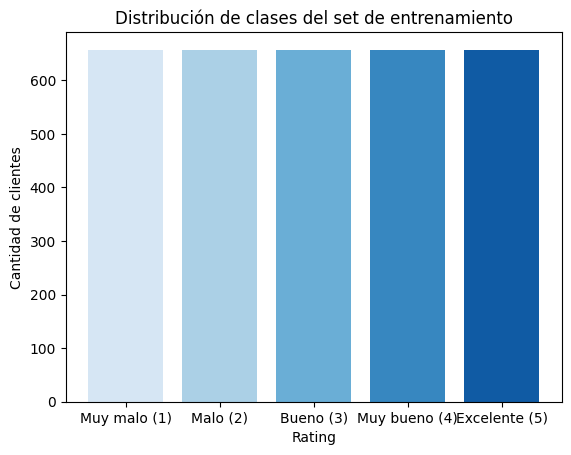

In [35]:
class_labels = ['Muy malo (1)', 'Malo (2)', 'Bueno (3)', 'Muy bueno (4)', 'Excelente (5)']
plt.bar(class_labels, class_counts, color = sns.color_palette("Blues", num_classes))
plt.xlabel('Rating')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de clases del set de entrenamiento')
plt.show()

In [37]:
# Determinar la dimensiones de entrada y salida 
in_shape = X_train_under.shape[1]
out_shape = y_train_under.shape[1]

print(f'Dimensiones de entrada: {in_shape} \nDimensiones de salida: {out_shape}')

Dimensiones de entrada: 115 
Dimensiones de salida: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [58]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics='accuracy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_4 (LSTM)               (None, 115, 128)          91648     
                                                                 
 dropout_5 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)              

In [61]:
# Entreno la red durante 50 epochs.
hist = model.fit(X_train_under, y_train_under, epochs=50, validation_data=(X_val_under,y_val_under))

Epoch 1/50
58/58 [==============================] - 9s 150ms/step - loss: 1.6082 - accuracy: 0.2149 - val_loss: 1.5805 - val_accuracy: 0.2581
Epoch 2/50
58/58 [==============================] - 8s 134ms/step - loss: 1.4260 - accuracy: 0.3146 - val_loss: 1.4117 - val_accuracy: 0.3377
Epoch 3/50
58/58 [==============================] - 8s 134ms/step - loss: 1.2552 - accuracy: 0.3849 - val_loss: 1.2824 - val_accuracy: 0.3831
Epoch 4/50
58/58 [==============================] - 8s 135ms/step - loss: 1.1450 - accuracy: 0.4602 - val_loss: 1.3579 - val_accuracy: 0.3977
Epoch 5/50
58/58 [==============================] - 8s 135ms/step - loss: 1.0432 - accuracy: 0.5160 - val_loss: 1.4200 - val_accuracy: 0.3847
Epoch 6/50
58/58 [==============================] - 8s 136ms/step - loss: 0.9227 - accuracy: 0.5966 - val_loss: 1.4047 - val_accuracy: 0.4367
Epoch 7/50
58/58 [==============================] - 8s 137ms/step - loss: 0.8067 - accuracy: 0.6557 - val_loss: 1.5684 - val_accuracy: 0.4269
Epoch 

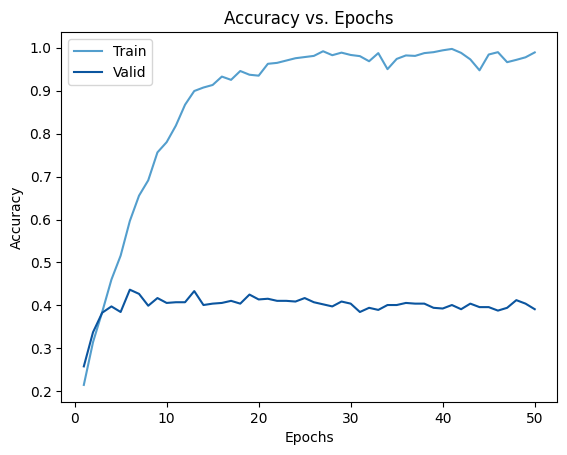

In [62]:
# Grafico Accuracy
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="Valid", color=blues_palette[5])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.show()

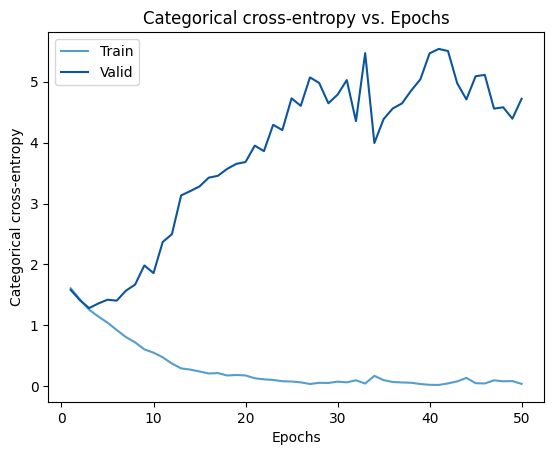

In [65]:
# Grafico loss function
epoch_count = range(1, len(hist.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epochs')
plt.title('Categorical cross-entropy vs. Epochs')
plt.show()

In [ ]:
# Evalúo el set de testeo
model.evaluate(X_test, y_test)

142/142 [==============================] - 6s 39ms/step - loss: 5.2514 - f1_score: 0.4199


[5.2514142990112305, 0.4198778569698334]

In [ ]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 6s 38ms/step
              precision    recall  f1-score   support

           0       0.15      0.29      0.20       164
           1       0.22      0.34      0.27       310
           2       0.23      0.32      0.27       565
           3       0.26      0.38      0.31       982
           4       0.80      0.48      0.60      2508

    accuracy                           0.42      4529
   macro avg       0.33      0.36      0.33      4529
weighted avg       0.55      0.42      0.46      4529



Text(98.2222222222222, 0.5, 'Predicted class')

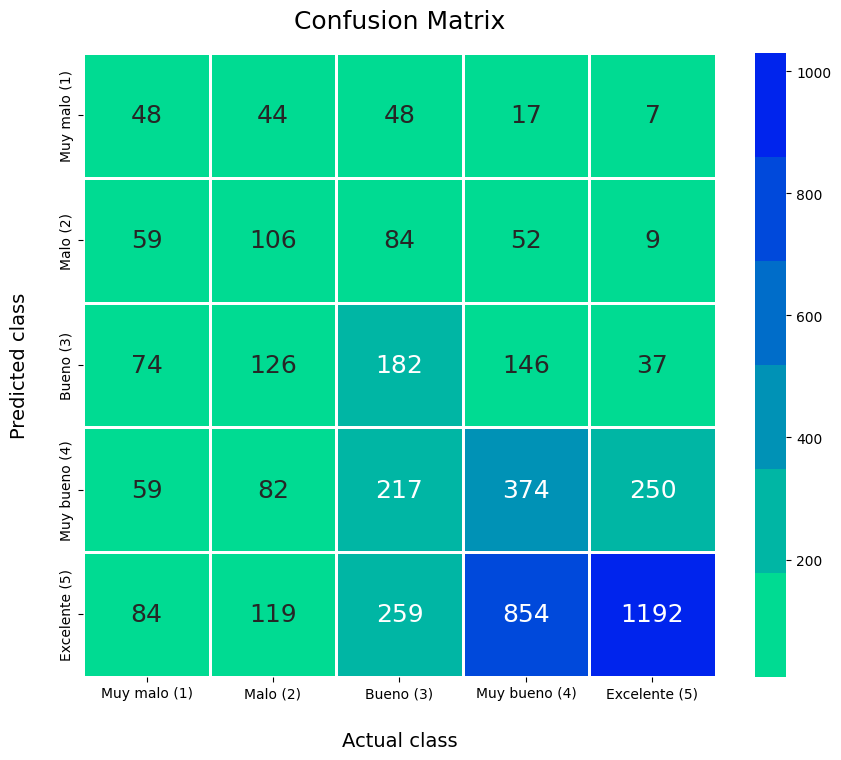

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels,y_pred_labels)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

### 3 - Entrenamiento del modelo con Embeddings Fasttext + LSTM

In [39]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [40]:
model_fasttext = FasttextEmbeddings()

In [43]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('Preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(vocab_size, len(word2index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word2index o bien elegir otra librería para preprocesamiento

for word, i in word2index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Preparing embedding matrix...
Number of null word embeddings: 2


In [42]:
# Definimos el modelo
model2 = Sequential()

model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(out_shape, activation="softmax"))

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 300)          600000    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           93440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [46]:
hist2 = model2.fit(X_train_under, y_train_under, epochs=100, validation_data=(X_val_under,y_val_under))

Epoch 1/100
77/77 [==============================] - 9s 78ms/step - loss: 1.6106 - accuracy: 0.2107 - val_loss: 1.5873 - val_accuracy: 0.2555
Epoch 2/100
77/77 [==============================] - 5s 65ms/step - loss: 1.5969 - accuracy: 0.2408 - val_loss: 1.5758 - val_accuracy: 0.2591
Epoch 3/100
77/77 [==============================] - 6s 77ms/step - loss: 1.5816 - accuracy: 0.2566 - val_loss: 1.5691 - val_accuracy: 0.2603
Epoch 4/100
77/77 [==============================] - 5s 67ms/step - loss: 1.5680 - accuracy: 0.2655 - val_loss: 1.6286 - val_accuracy: 0.2299
Epoch 5/100
77/77 [==============================] - 5s 66ms/step - loss: 1.5552 - accuracy: 0.2846 - val_loss: 1.5361 - val_accuracy: 0.2993
Epoch 6/100
77/77 [==============================] - 5s 64ms/step - loss: 1.5370 - accuracy: 0.2976 - val_loss: 1.5402 - val_accuracy: 0.2956
Epoch 7/100
77/77 [==============================] - 5s 66ms/step - loss: 1.5214 - accuracy: 0.2793 - val_loss: 1.5369 - val_accuracy: 0.2883
Epoch 

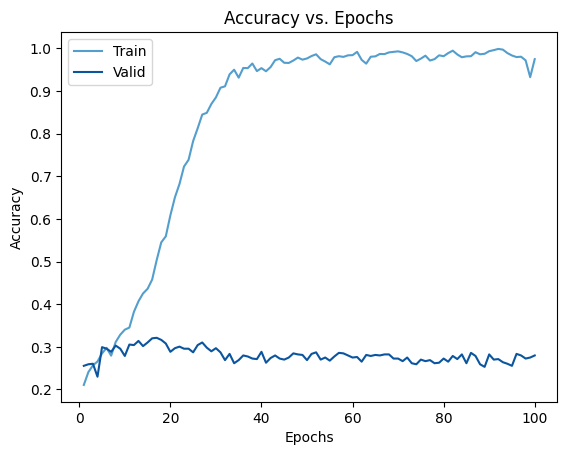

In [49]:
# Grafico Accuracy
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist2.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["accuracy"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_accuracy"], label="Valid", color=blues_palette[5])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.show()

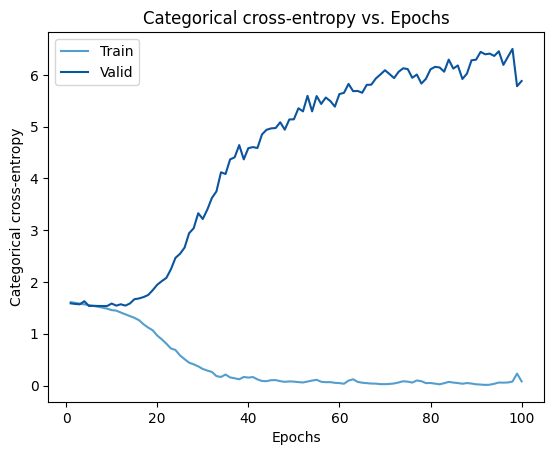

In [50]:
# Grafico loss function
epoch_count = range(1, len(hist2.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epochs')
plt.title('Categorical cross-entropy vs. Epochs')
plt.show()

In [51]:
# Evalúo el set de testeo
model2.evaluate(X_test, y_test)

142/142 [==============================] - 4s 25ms/step - loss: 5.5941 - accuracy: 0.3104


[5.5941290855407715, 0.31044381856918335]

In [54]:
from sklearn.metrics import classification_report

y_pred_prob = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 3s 24ms/step
              precision    recall  f1-score   support

           0       0.09      0.32      0.14       164
           1       0.11      0.27      0.15       310
           2       0.15      0.20      0.17       565
           3       0.25      0.30      0.27       982
           4       0.72      0.34      0.47      2508

    accuracy                           0.31      4529
   macro avg       0.26      0.29      0.24      4529
weighted avg       0.48      0.31      0.35      4529



Text(98.2222222222222, 0.5, 'Predicted class')

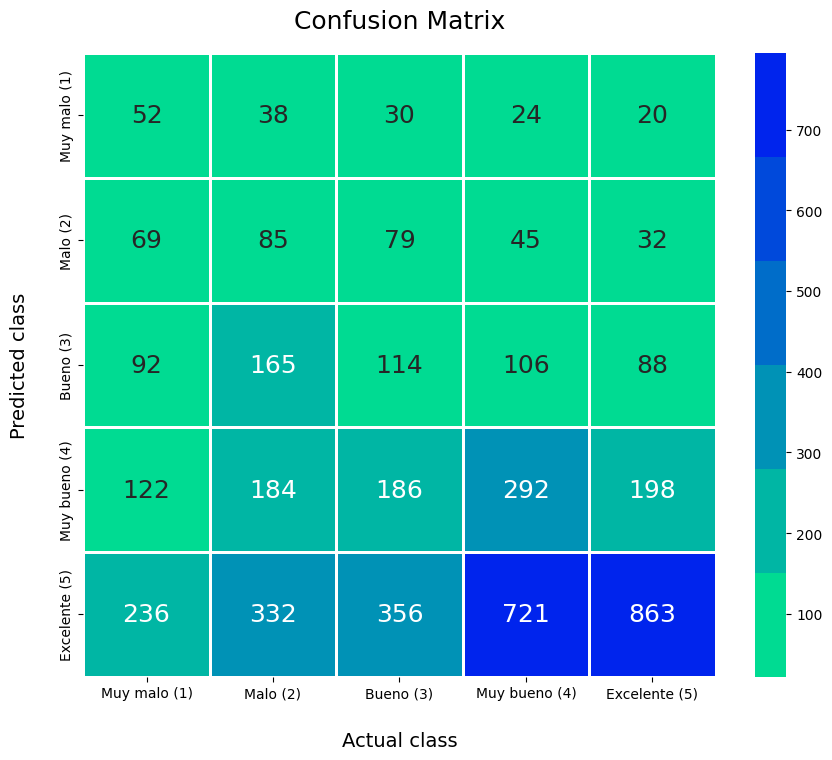

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels,y_pred_labels)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

### 4 - Testting de los modelos

In [64]:
# Creo mi diccionario de indices a palabras (opuesto a word2index)
index2word = {index: word for word, index in word2index.items()}
index2word[0] = '' # Agrego el indice 0 como vacio

# Selecciono 5 reviews random 
for i in range(5):
    idx = np.random.randint(len(y_test))
    review_tokens = [index2word[word] for word in X_test[idx]]
    review = " ".join(review_tokens).lstrip()

    # Predicciones de ambos modelos
    pred1 = model.predict(X_test[idx].reshape(1, -1))
    pred2 = model2.predict(X_test[idx].reshape(1, -1))

    print(f"Review {i+1}: {review}")
    print(f"Predicción modelo 1: {np.argmax(pred1)}")
    print(f"Predicción modelo 2: {np.argmax(pred2)}")
    print(f"Valor verdadero: {np.argmax(y_test[idx])}")
    print('-'*85)

1/1 [==============================] - 0s 20ms/step
Review 1: i noticed some reviewers didn't like the loose shape of the dress it is indeed a dress with a looser silhouette than most but that's what makes it unique and expensive looking i loved the extra material in the dress especially in the back it and beautifully i can imagine wearing this dress for many occasions and feeling instantly chic with it was also very figure flattering i ordered the size l and it was a perfect knee length so i would say this
Predicción modelo 1: 3
Predicción modelo 2: 3
Valor verdadero: 4
-------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
Review 2: this dress is short but super flattering i was surprised when i tried it on in store that i liked it as much as i did the lace detail around the neck is unique and beautiful i'm 135 5'8 32dd and the small fits perfectly it's easy to wear and can be dressed down with tights 

### 5 - Conclusiones

Se exploraron diversas arquitecturas con el objetivo de mejorar el desempeño del modelo. Se realizaron cambios en el tipo y cantidad de capas, así como en la configuración de los hiperparámetros, como el número de nodos, el porcentaje de dropout, el optimizador y la tasa de aprendizaje. A pesar de estos esfuerzos, no se logró obtener un puntaje accuracy en el conjunto de prueba superior al 40%.

Sin embargo, al realizar múltiples predicciones en el conjunto de prueba, se observa que las predicciones no son tan desfavorables en general. Es importante destacar que no se encontraron casos en los que se predijera el rating opuesto, como clasificar la clase 0 (Muy malo) cuando en realidad era 4 (Excelente) o viceversa. Por lo tanto, se concluye que este modelo al menos tiene la capacidad de distinguir entre sentimientos positivos y negativos. 

Una opcion para mejorar el desempeño puede ser transformar este problema en una clasificación binaria, donde se determine si el cliente está satisfecho o no con el producto. Otra cambio podria ser en lugar de balancear al dataset con un undersample utilizar el oversample y asi llevar a todas las clases al tamaño de la mayoritaria a costa de un mayor procesamiento de datos.